In [1]:
# Main packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Graphical packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

plt.style.use('seaborn-white')
plt.rcParams["figure.figsize"] = [18, 8]

# Extra packages
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.colors

<a id='main_cell'></a>

## Building Energy Consumption


Each building, as an independent system, has its own characteristics and main features, due to that each building was analyzed individually. In a way to simplify these analyses, it is mandatory to identify the patterns that dynamically affect building’s energy consumption. These patterns may rely on key factors that at first sight are critical to energy use, such as occupancy, weather conditions and structural characteristics.

The **stochastic behaviour of the occupants** through their presence and activities in the building, influences energy consumption, not only passively by their metabolic heat produced, but also actively by their energy use (e.g. use of hot water, electrical appliances, lighting, and building openings) which results in an increase of internal heat gains and energy consumption, respectively.


Additionally, **weather conditions parameters, such as outdoor temperature, relative humidity, and solar radiation** are also important factors that may impact building’s indoor thermal comfort and subsequently its inhabitants, mostly due to their annual variation. Thermal comfort can be reached through the proper use of the HVAC system, which is one of the major contributors in terms of energy use.


Furthermore, **buildings’ structure characteristics** is another factor that may affect the indoor environment and consequently, energy consumption. Diverse type of structures and construction materials impact negatively or positively buildings’ overall thermal properties. In a well-conceived building, its structure is used as an energy storage medium that supports building thermal management, by adapting to the various weather conditions scenarios.

To distinguish the different patterns caused by the earlier mention factors, each **building energy consumption was evaluated in monthly, weekly and daily temporal granularities, with the data acquired from the previous year of the forecast, 2017.**

In [2]:
dt_01 = pd.read_csv('Preprocessed_Data/_01_dt_01.csv', index_col=[0], parse_dates=[0], header=0)['2017']
dt_01.head()

,civil,south_tower,wt_temp,wt_tmpap,wt_hr,wt_max_windgust,wt_mean_windspd,wt_mean_pres,wt_mean_solarrad,wt_rain_day,t_hour,t_month,t_dayofweek,t_year,miss_civil,miss_south_tower,miss_wt
timestamp,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,74.897706,100.810001,8.5,5.6,75.0,3.8,2.3,1029.0,1.4,0.0,0,1,6,2017,0,0,0
2017-01-01 01:00:00,75.173556,99.054135,7.9,4.7,76.3,4.3,2.7,1028.2,1.5,0.0,1,1,6,2017,0,0,0
2017-01-01 02:00:00,74.208175,98.539567,7.3,3.7,80.3,4.8,3.3,1028.0,1.4,0.0,2,1,6,2017,0,0,0
2017-01-01 03:00:00,73.735889,101.435784,6.8,3.0,81.3,5.0,3.5,1028.0,1.5,0.0,3,1,6,2017,0,0,0
2017-01-01 04:00:00,75.102351,98.481664,6.5,2.3,81.2,6.8,4.0,1028.0,0.9,0.0,4,1,6,2017,0,0,0


In [3]:
def dt_preparation(groupby=False, stats='mean', hours='day'):
    dt_buildings = dt_01[['civil', 'south_tower', 't_month', 't_hour', 't_dayofweek']]
    
    if groupby==True:
        dt_buildings = day_or_night(dt_buildings, hours)
        dt_buildings = assign_names(dt_buildings)
        dt_buildings = groupby_and_index(dt_buildings, stats=stats)
        
        
    dt_buildings = assign_names(dt_buildings)
    dt_buildings = pd.melt(dt_buildings, id_vars=['name_months', 'name_weekdays'] , value_vars=['civil', 'south_tower'],
                           var_name='Building' ,value_name='Consumption (kWh)')

    return dt_buildings

def assign_names(dt):
    # Dictionary to create new columns with names instead of integers for days of week and months
    weekday_keys = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    months_keys = {1:'January', 2:'February', 3: 'March', 4:'April',5: 'May', 6:'June',
                   7:'July', 8:'August', 9:'September', 10:'October',11:'November', 12:'December'}
   
    # Apply dictionaries
    dt['name_weekdays'] = dt['t_dayofweek'].apply(lambda x: weekday_keys.get(x))
    dt['name_months'] = dt['t_month'].apply(lambda x: months_keys.get(x))
    
    return dt

def day_or_night(dt, hours):
    '''
    Select Days of Week and Hours 
    '''
    # Weekdays because is when there is more movement in the faculty
    weekdays = [i for i in range(0, 5)]
    # Day hours from 8 am to 9 pm
    day_hours = [i for i in range(8, 21)]
    # Night hours from 9 pm to 7 am
    night_hours = [i for i in range(0, 8)] + [i for i in range(21, 24)]
    
    # Split the data frame based on time
    if hours == 'day':
        return dt[dt.t_hour.isin(day_hours) & dt.t_dayofweek.isin(weekdays)]
    elif hours == 'night':
        return dt[dt.t_hour.isin(night_hours) & dt.t_dayofweek.isin(weekdays)]
    
def groupby_and_index(dt, stats):
    '''
    Groups by month only
    
    Input: DataFrame
           stats = ['mean', 'max', 'min', 'sum']
    Output: DataFrame Grouped
          
    '''
    indexes = ['January','February','March','April','May','June',
        'July','August','September','October','November','December']
    
    if stats == 'mean':
        return dt.groupby('name_months').mean().reindex(indexes).reset_index()
    elif stats == 'max':
        return dt.groupby('name_months').max().reindex(indexes).reset_index()
    elif stats == 'min':
        return dt.groupby('name_months').min().reindex(indexes).reset_index()
    else:
        return dt.groupby('name_months').sum().reindex(indexes).reset_index()
    
def dt_wt_preparation(wt, hours):
    '''
    Prepares the weather data to be analized with the energy consumption
    Input: wt = ['temp', 'hr', 'mean_solarrad']
           hours = ['day', 'night']
    Output: DataFrame
    '''
    dt_wt = dt_01[['t_hour', 't_month', 't_dayofweek', 'wt_temp', 'wt_hr', 'wt_mean_solarrad']]
    
    # Select if day or night hours
    dt_wt = day_or_night(dt_wt, hours)
    dt_wt = assign_names(dt_wt)
        
    dt_wt_max = groupby_and_index(dt_wt, stats='max')
    dt_wt_min = groupby_and_index(dt_wt, stats='min')
    
    wt = 'wt_'+ wt
    
    dt = dt_wt_min[['name_months', wt]]
    dt[wt+'_max'] = dt_wt_max[wt]
    dt.columns = ['months', wt+'_min', wt+'_max']
    
    dt = pd.melt(dt, id_vars=['months'], value_vars=[wt+'_max', wt+'_min'], var_name= wt+'_var', value_name=wt)
    
    return dt

# Function to Box Plot
def boxplot(dt, temp, building, hue_name):
    name = building.split('_')

    if len(name) > 1:
        name = name[0]+' '+name[1]   
    else:
        name = name[0]
    
    plt.figure()
        
    if temp == 'name_months':   

        plot = sns.boxplot(x=temp, y=building, data=dt, hue=hue_name)
        plot.set_xlabel("Months",fontsize=15)
        plot.set_ylabel("Consumption (kWh)",fontsize=15)
        
    elif temp == 'name_weekdays':

        plot = sns.boxplot(x=temp, y=building, data=dt, hue=hue_name, order=["Monday", "Tuesday", "Wednesday", 
                                                                             'Thursday', 'Friday', 'Saturday', 'Sunday'])
        plot.set_xlabel("Weekday",fontsize=15)
        plot.set_ylabel("Consumption (kWh)",fontsize=15)

    plot.yaxis.set_label_coords(-0.04, 0.5)
    plot.xaxis.set_label_coords(0.5, -0.06)
    plot.tick_params(labelsize=15)
    plot.legend(loc=0, prop={'size': 15})

def bar_line_plot(dt_energy, dt_wt, wt='wt_temp', day=True):    
    if day == True:
        title = '(from 8 am till 8 pm)'
    else:
        title = '(from 9 pm till 7 am)'
    
    fig, ax1 = plt.subplots()
    # bar plot creation
    ax1 = sns.barplot(x='name_months', y='Consumption (kWh)', data = dt_energy, hue='Building', palette=['seagreen', 'darkorange'])
    # specify we want to share the same x-axis
    ax2 = ax1.twinx()
    # line plot creation
    ax2 = sns.lineplot(x='months', y=wt, data = dt_wt, hue=wt+'_var',sort=False,palette=['red', 'blue'])
    ax1.set_title('Average Energy Consumption by Month '+title, fontsize=24)
    
    ax1.set_ylim(0, dt_energy.iloc[:,-1].max()+50)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    
    ax1.set_xlabel('Month', fontsize=16)
    ax1.set_ylabel('Consumption (kWh)', fontsize=16)
    if wt == 'wt_temp':
        label = 'Temperature (ºC)'
    elif wt == 'wt_hr':
        label = 'Relative Humidity (%)'
    elif wt == 'wt_mean_solarrad':
        label = 'Solar Radiation (kWh/m^2)'
    
    ax2.set_ylabel(label, fontsize=16)

    ax1.legend(loc=2, prop={'size':15})
    ax2.legend(loc=0, prop={'size': 15})
    plt.show()

---

### Monthly Analysis

For this analysis, the yearly energy consumption of the weekdays was divided in daytime (from 8 am till 8 pm) and nighttime (from 9 pm till 7 am). In addition, it is also presented a boxplot for each building, without any filter applied.

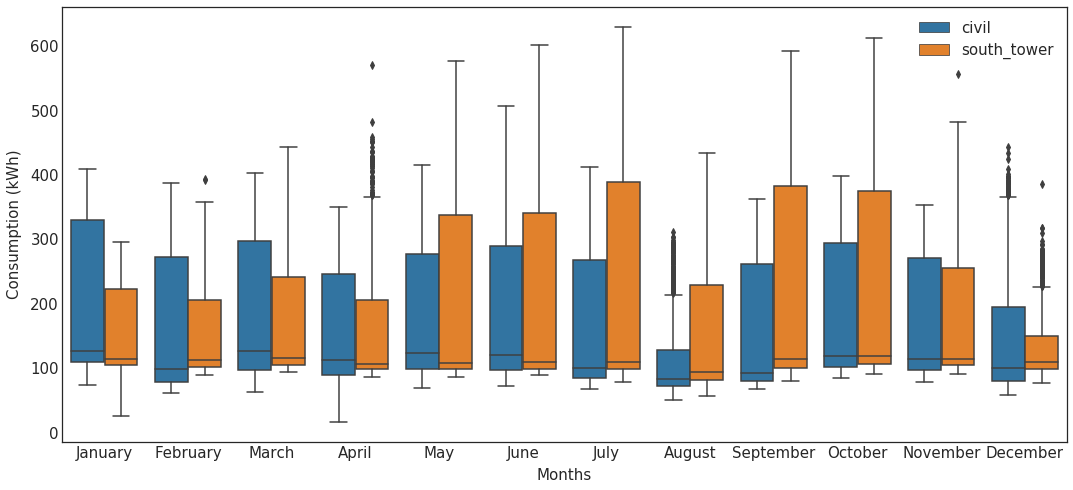

In [4]:
boxplot(dt_preparation(groupby=False), 'name_months', 'Consumption (kWh)', 'Building')

#### Daytime

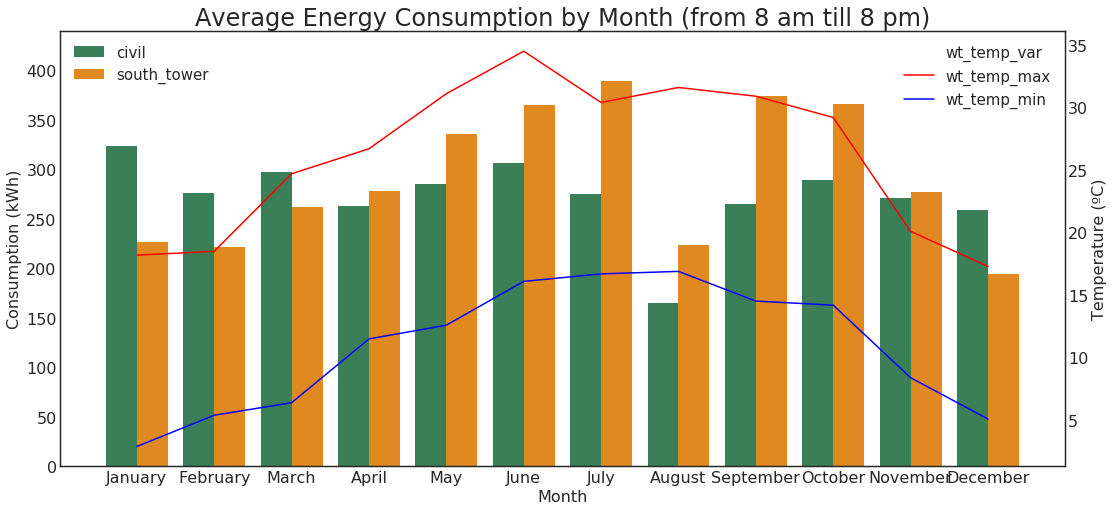

In [5]:
bar_line_plot(dt_preparation(groupby=True, stats='mean', hours='day'), dt_wt_preparation('temp', hours='day'), wt='wt_temp', day=True)

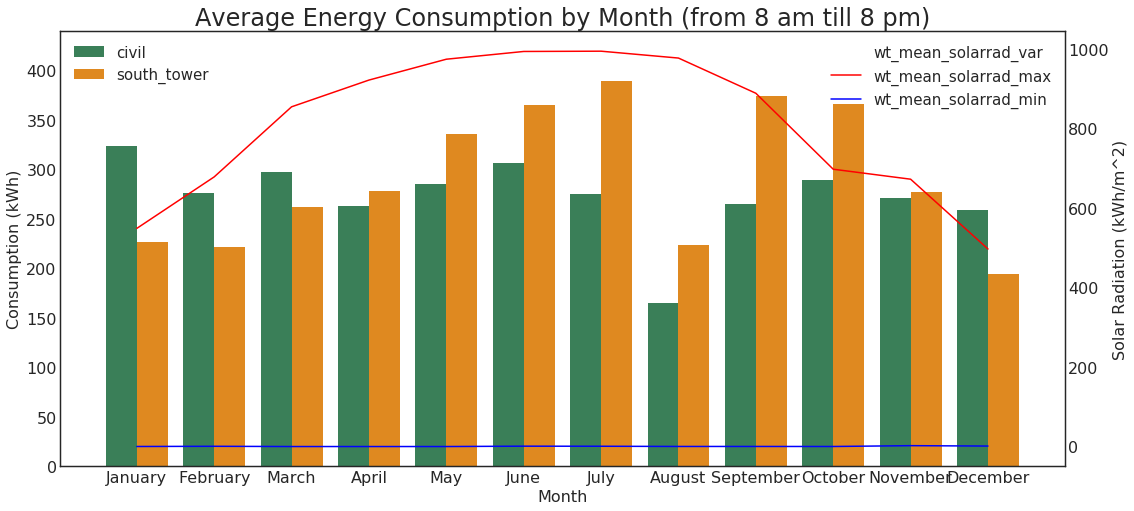

In [6]:
bar_line_plot(dt_preparation(groupby=True, stats='mean', hours='day'), dt_wt_preparation('mean_solarrad', hours='day'), wt='wt_mean_solarrad', day=True)

In general, during the daytime, it is possible to see a higher mean consumption tendency, during the cooling season when compared with heating season. This tendency is highly related to HVAC system energy use to maintain the indoor thermal comfort, in the presence of more adverse conditions, which occurs during summer. Although there is an exception of this tendency, in August, that shows the lowest mean energy consumption when compared with the rest of the months during the year, caused by the two weeks summer break of all campus facilities, which is clearly in boxplot.

Moreover, it is noticeable that South tower is more exposed to the outside conditions than Civil building, achieving higher mean consumptions in the cooling season, this is mostly due to the thermal properties of the glazed facades that surrounds South tower, being more vulnerable to solar energy.

In South Tower it is also perceptible that the consumption fluctuation follows the maximum and minimum temperature variations along the year. This consumption curve is characteristic of buildings using natural gas and electricity for cooling and heating seasons, respectively. In contrast, Civil building presents a more stable consumption curve which is substantiated by the main use of electricity.

#### Nighttime

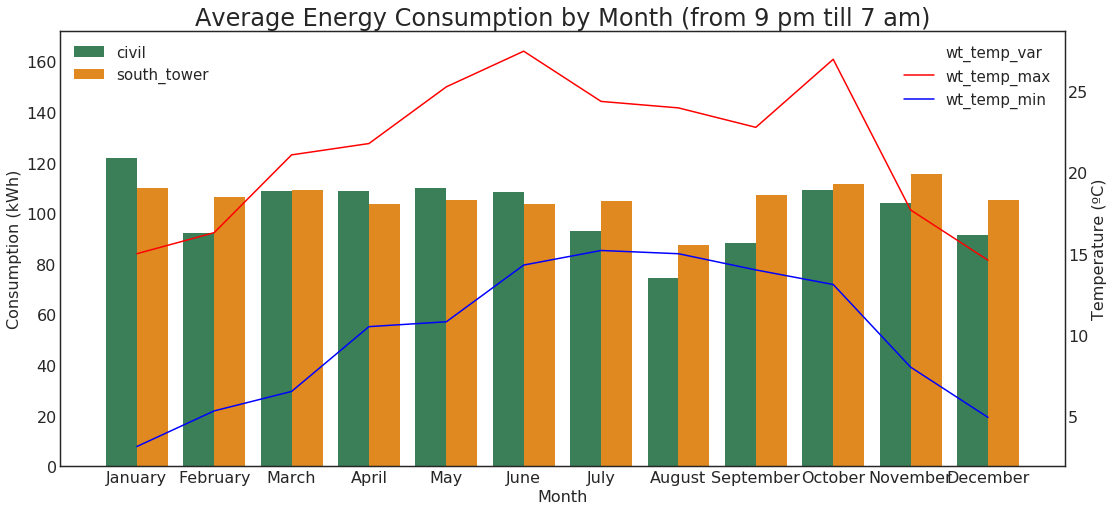

In [7]:
bar_line_plot(dt_preparation(groupby=True, stats='mean', hours='night'), dt_wt_preparation('temp', hours='night'), day=False)

During nighttime, one main behaviour of Civil building' consumption is noticeable. The existence of a study area open 24 hours a day, creates a pattern with higher mean consumption in the months corresponding to the two semesters and evaluation periods.

---

### Weekly Analysis

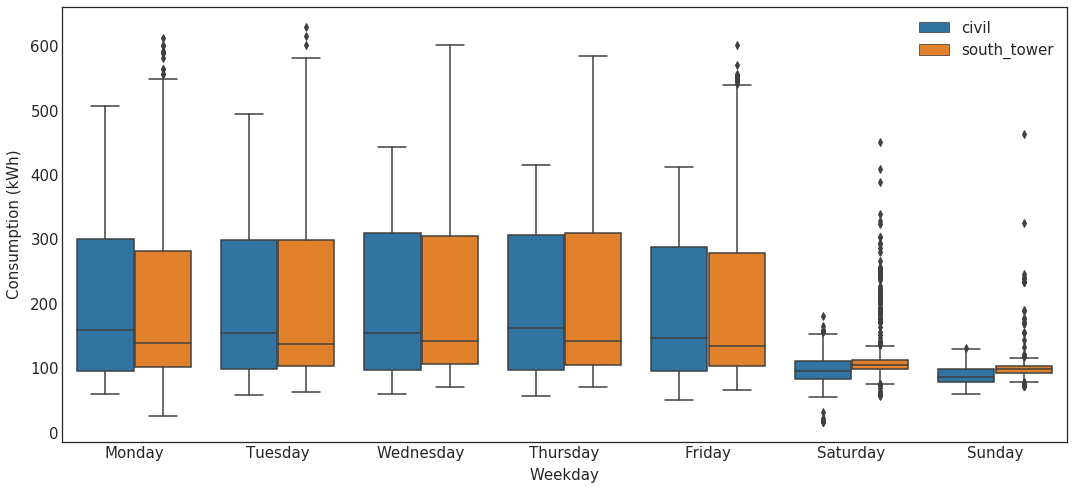

In [8]:
boxplot(dt_preparation(groupby=False), 'name_weekdays', 'Consumption (kWh)', 'Building')

In each building there is a 7 days cycle pattern that repeats almost through the whole year, as it is represented by the weekly boxplots.

As expected, most of the buildings’ energy use occurs during weekdays since it is when the majority of buildings’ activities take place. It is also noticeable a slight decrease in energy expenditure in the last weekday, Friday, probably due to the arriving of week-end and people’s tendency to leave earlier. During the weekend, there is an abrupt fall in energy con-sumption, although Saturday energy use is slightly higher than Sunday, due to weekend opening hours.

Nevertheless, this pattern can be altered by local or national holidays that consequently may reduce buildings’ occupancy rate resulting in less energy expenditure.

---

### Hourly Analysis

In [9]:
def daily_representation(data, name, drop_nan=False):
    '''
    SHOWS DAILY DATA 
    '''
    # Selection of the column
    building = dt_01[[name, 't_hour']].reset_index().set_index('timestamp')
    building.index = building.index.date
    
    # Pivot by hour
    building_pivot = building.pivot(columns='t_hour')

    # Drop a day when any hour is missing
    if drop_nan == False:
        # Fill with values
        building_pivot = building_pivot.fillna(method='ffill').fillna(method='bfill')
        
    elif drop_nan == True:
        # Drop values
        building_pivot = building_pivot.dropna()        
        
    # Plot
    building_pivot.T.plot(legend=False, color='blue', alpha=0.05)
    plt.xlim(0, 23);

    return building_pivot

def k_means_score(building_pivot):
    ''' 
    CHECK SCORES FOR DIFFERENT K 
    '''
    
    # Empty list for silhouette score
    silhoute_scores = []

    # Number of clusters to try out
    n_cluster_list = np.arange(2, 16).astype(int)

    # Create a copy of dataframe
    X = building_pivot.values.copy()

    # Scale for K-Means
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # For loop to represent clusters_list and correspondent silhouette score
    for n_cluster in n_cluster_list:

        kmeans = KMeans(n_clusters=n_cluster)
        cluster_found = kmeans.fit_predict(X)
        silhoute_scores.append(silhouette_score(X, kmeans.labels_))

    # Dataframe creation
    score = pd.DataFrame(data=silhoute_scores,index=n_cluster_list,columns=['silhoute_score'])

    # Plotting values
    score.plot()
    plt.grid(b=True, which='major')
    plt.xticks(np.arange(1, 15, 1));
    plt.legend(prop={'size': 20}).get_texts()[0].set_text('Silhouette Score')
    plt.xlim(n_cluster_list[0], n_cluster_list[-1])
    
    plt.tick_params('y', labelsize=15)
    plt.tick_params('x', labelsize=15)
    
    return X

def clustering_analysis(building_pivot, X_building, clusters):
    ''' 
    IMPLEMENTATION OF BEST K NUMBER 
    '''
    kmeans = KMeans(n_clusters = clusters)

    # Will attribute 24h data to the different types of clusters (0, 1 or 2)
    cluster_found = kmeans.fit_predict(X_building)

    # Convert each day to series
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    building_pivot

    # Append cluster data
    clustered_building_pivot = building_pivot.set_index(cluster_found_sr, append=True)

    return clustered_building_pivot

def list_of_colors(clusters, random_color=False):
    ''' 
    REPRESENTATION OF MEAN K 
    '''
        
    if random_color==False:
        color_list = ['blue', 'green', 'red', 'black', 'yellow','orange', 'grey']
        color_list = color_list[:clusters]
    else:
        import random
        random.seed(10)
        number_of_colors = clusters
        color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
        
    return color_list

def cluster_representation(cl_building_pivot, clusters, building_name, random_color=False):
    ''' 
    CLUSTER REPRESENTATION 
    '''
    
    fig, ax = plt.subplots(1, 1)
    
    # List of colors
    color_list = list_of_colors(clusters, random_color)
    
    # Unique values of the clusters --- 0, 1 and 2, in this case
    cluster_values = sorted(cl_building_pivot.index.get_level_values('cluster').unique())

    # 
    for cluster, color in zip(cluster_values, color_list):
        cl_building_pivot.xs(cluster, level=1).T.plot(
            ax=ax, legend=False, alpha=0.04, color=color, label= f'Cluster {cluster}')
        
        cl_building_pivot.xs(cluster, level=1).mean().plot(
            ax=ax, color=color, alpha=1, ls='--')
    
    ax.set_ylabel('Consumption (kWh)', fontsize=20)
    ax.set_xlabel('Hour', fontsize=20)
    plt.xticks(np.arange(24), ('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'
                               , '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))

    ax.tick_params('y', labelsize=20)
    ax.tick_params('x', labelsize=15)
    ax.yaxis.set_label_coords(-0.04, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.08)
    ax.set_xlim(0, 23)
    
    # Cluster legend
    custom_lines = [Line2D([0], [0], color='blue'), Line2D([0], [0], color='green'),  Line2D([0], [0], color='red'), Line2D([0], [0], color='black'), 
                    Line2D([0], [0], color='yellow'), Line2D([0], [0], color='orange'),Line2D([0], [0], color='grey')][:clusters]
    leg_cl = ['k=0', 'k=1', 'k=2', 'k=3', 'k=4', 'k=5', 'k=6'][:clusters]  
    
    ax.legend(custom_lines, leg_cl,  prop={'size': 20})
    
    return cluster_values, color_list

def validation_tSNE(cl_building_pivot, X_building, cluster_values, color_list):
    ''' 
    RESULTS VALIDATION WITH t-SNE 
    '''

    tsne = TSNE()
    results_tsne = tsne.fit_transform(X_building)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=cl_building_pivot.index.get_level_values('cluster'),
        cmap=cmap, alpha=0.6, s=100)
    
    ax.tick_params('y', labelsize=15)
    ax.tick_params('x', labelsize=15)
    
    legend_elements = [Line2D([0], [0], color='blue', lw=2, label='k=0'),
                        Line2D([0], [0], color='green', lw=2, label='k=1'),
                        Line2D([0], [0], color='red', lw=2, label='k=2'),
                       Line2D([0], [0], color='black', lw=2, label='k=3')][0:len(cluster_values)]
    ax.legend(handles=legend_elements)
                    
    plt.legend(handles=legend_elements, prop={'size': 20})

In this analysis each building was evaluated individually to simplify the visualization and gathered
each different daily consumption curve characteristics.

To recognize the different daily consumption patterns a clustering algorithm was used, known as [**k-means**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). In this context, the algorithm clusters the most similar days, based on the chosen **number of clusters - k**. To identify the **k**, a range between 2 to 15 clusters was tested via the [**silhouette score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), 
and the one selected was posteriorly represented by the [**t-SNE algorithm**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) in a lower-dimesional space attached to the correspondent building consumption patterns.

#### Before Clustering

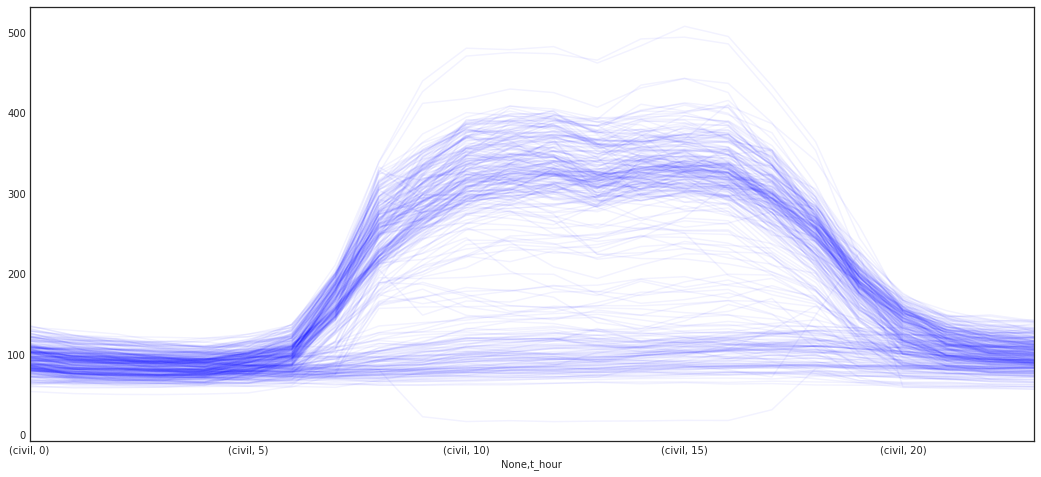

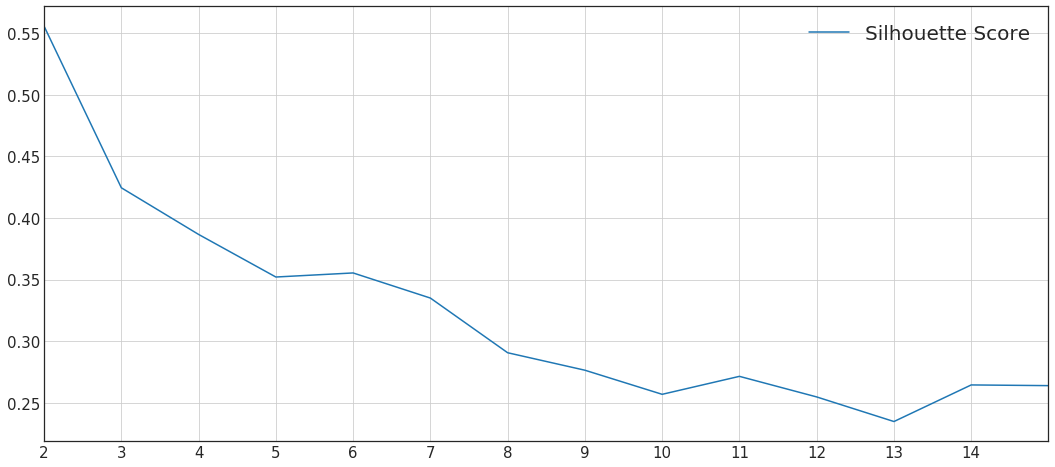

In [10]:
# Civil building Consumptions Patters
civil_pivot = daily_representation(dt_01, 'civil', drop_nan=True)
X_civil = k_means_score(civil_pivot)

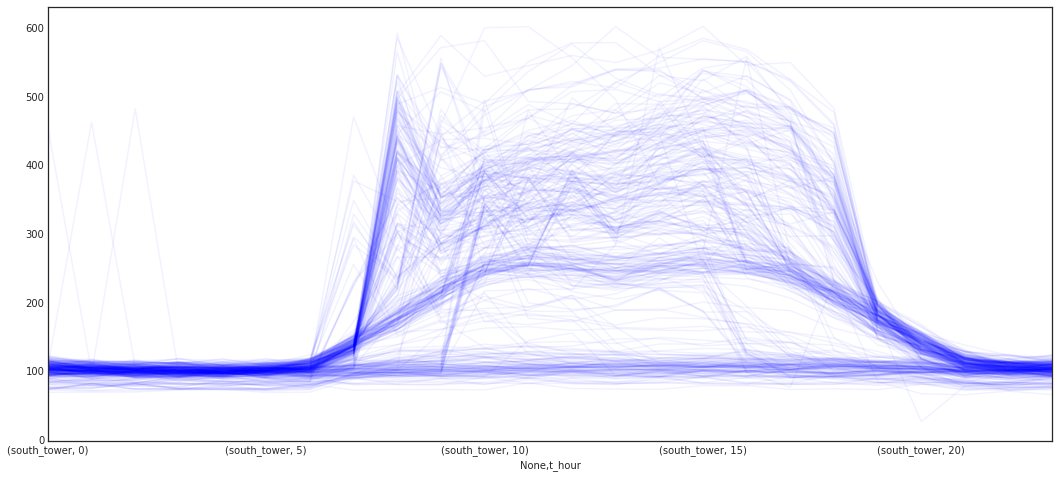

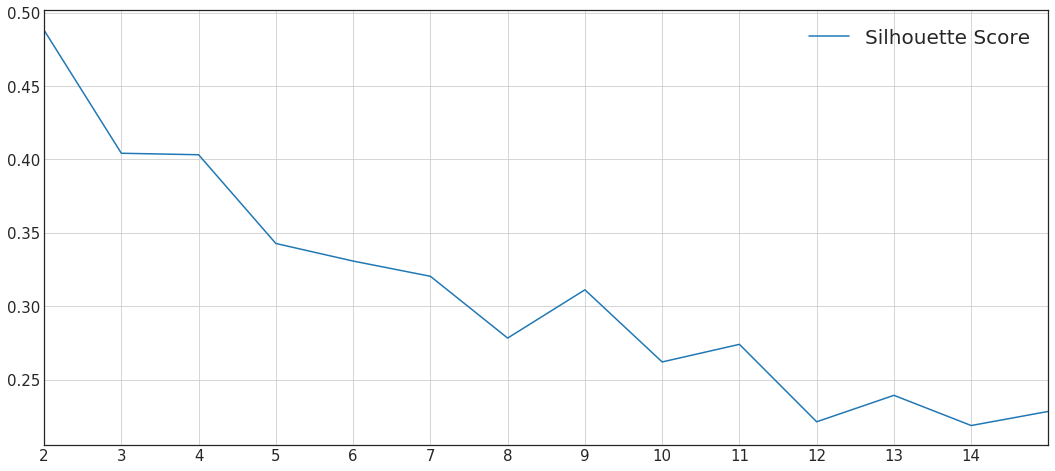

In [11]:
# South Tower Consumptions Patters and Silhoutte Score
stw_pivot = daily_representation(dt_01, 'south_tower', drop_nan=True)
X_stw = k_means_score(stw_pivot)

From the **silhouette score plots**, although most of the scores indicate the use of two clusters per building, in the scope of this analysis the evaluation will start at **k=3**, in attempt to distinguish a **typical non-working day** from a **typical working day during cooling and heating season**.

With that in mind, **Civil building** maintains the **k=3**, once it was the next highest silhouette score. As regards to
**South tower**, the selection of k was controversial and a **k=4** was adopted, since all the clusters represent distinct
patterns, regardless of the slightest lower score.

#### After Clustering

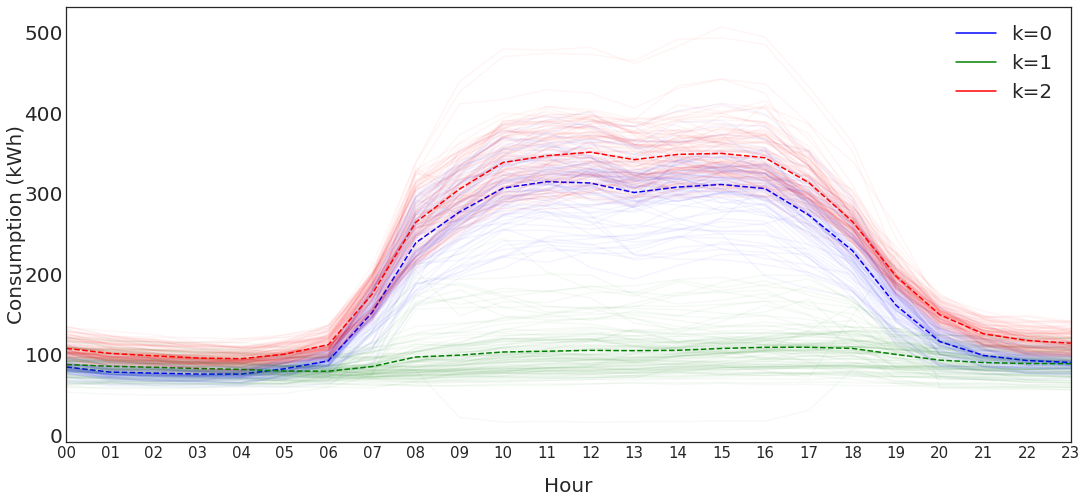

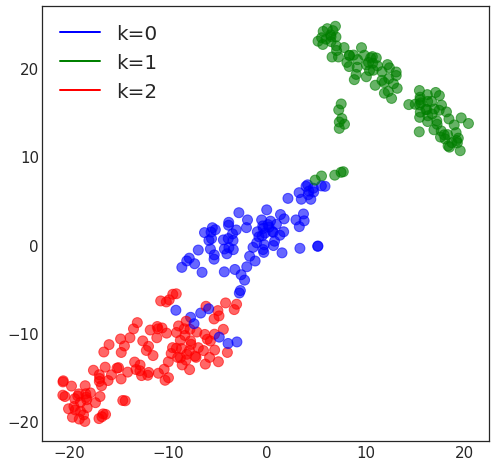

In [12]:
# Civil building consumption patterns clustered and t-SNE distribution
n_clusters = 3
clustered_civil_pivot = clustering_analysis(civil_pivot, X_civil, n_clusters)
cluster_values_civil, color_list_civil = cluster_representation(clustered_civil_pivot, n_clusters, 'civil')
validation_tSNE(clustered_civil_pivot, X_civil, cluster_values_civil, color_list_civil)

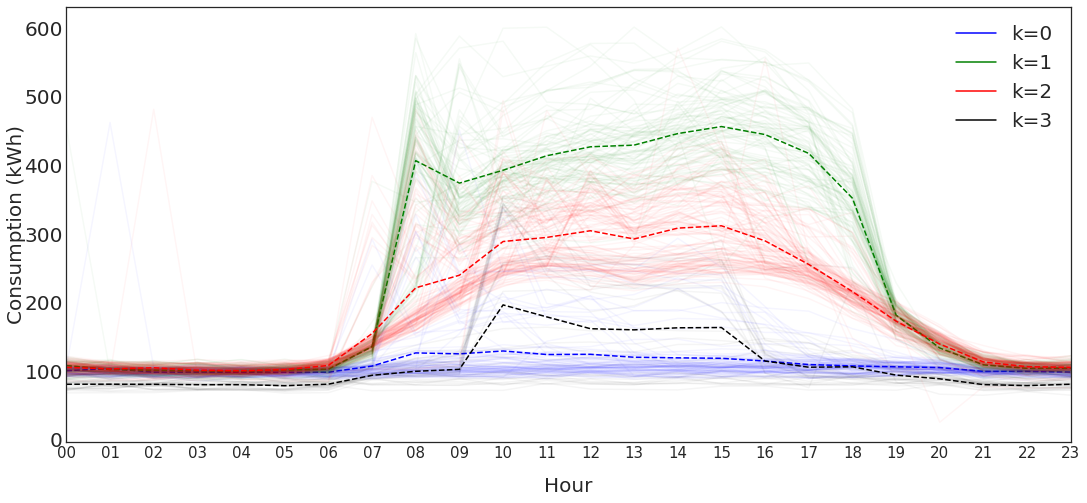

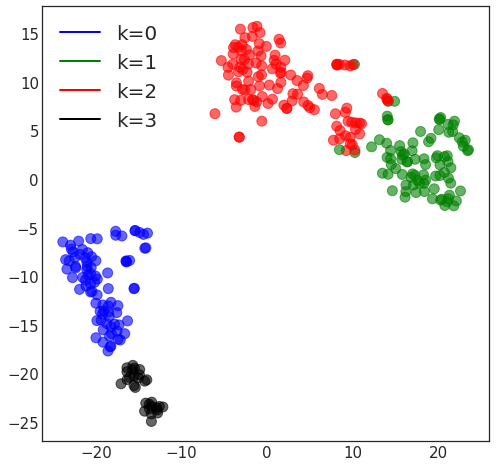

In [13]:
# South tower building consumption patterns clustered and t-SNE distribution
n_clusters = 4
clustered_stw_pivot = clustering_analysis(stw_pivot, X_stw, n_clusters)
cluster_values_stw, color_list_stw = cluster_representation(clustered_stw_pivot, n_clusters, 'south_tower')
validation_tSNE(clustered_stw_pivot, X_stw, cluster_values_stw, color_list_stw)

As it can be seen from the previous analyze, energy consumption daily patterns differ due to external conditions, which are mostly linked with building's occupancy rate and external weather conditions, as [previous explained](#main_cell). Because of that, there is a need to understand how well new features can define the behaviour that was distinguish by the **k-Means** algorithm. 

In the next notebook **03-00-Feature Generation** we will define that features and check their quality based on the clusters identified in this notebook.

In [15]:
clustered_stw_pivot

south_tower                                      \
t_hour                      0           1           2           3    
           cluster                                                   
2017-01-01 0        100.810001   99.054135   98.539567  101.435784   
2017-01-02 2         92.215521   94.693530   97.909850   95.432934   
2017-01-03 2        103.791652  101.907308   91.747932   92.043999   
2017-01-04 2        115.529471  104.092526  102.907601   99.679700   
2017-01-05 2        113.875645  113.996694  112.396181  111.547965   
...                        ...         ...         ...         ...   
2017-12-27 3         92.080051   84.691474   86.591331   93.426885   
2017-12-28 3         83.528835   81.366778   80.075006   82.071659   
2017-12-29 3         86.213327   78.180393   78.086874   76.695248   
2017-12-30 3         80.203047   78.496562   79.258253   81.030725   
2017-12-31 3         83.445369   80.222712   81.085350   80.431598   

                                                                    \
t_hour                      4           5           6           7    
           cluster                                                   
2017-01-01 0         98.481664   97.805844   94.464760   94.983261   
2017-01-02 2         95.678309   96.260175  104.752833  133.987914   
2017-01-03 2        100.451661   99.002787  111.190935  140.103948   
2017-01-04 2        103.385460  107.459174  114.599536  147.442271   
2017-01-05 2        102.830688  108.672723  117.625760  146.875263   
...                        ...         ...         ...         ...   
2017-12-27 3         84.324394   84.469915   96.864765  118.732026   
2017-12-28 3         78.375950   80.231670   83.700140  111.287294   
2017-12-29 3         84.071590   77.170485   81.485861  105.796607   
2017-12-30 3         80.858328   78.717466   78.598164   89.924768   
2017-12-31 3         81.915869   78.394086   83.417838   87.818865   

                                            ...                          \
t_hour                      8           9   ...          14          15   
           cluster                          ...                           
2017-01-01 0        104.622170  101.362150  ...  107.381825  103.988083   
2017-01-02 2        283.762017  240.998945  ...  281.572429  289.854890   
2017-01-03 2        294.723725  263.701751  ...  253.037640  238.712343   
2017-01-04 2        181.333150  214.044129  ...  253.200640  252.589715   
2017-01-05 2        176.543630  196.504260  ...  231.478900  248.707188   
...                        ...         ...  ...         ...         ...   
2017-12-27 3        137.782386  150.152981  ...  158.988466  158.192471   
2017-12-28 3        130.408010  129.490092  ...  138.896080  138.783989   
2017-12-29 3        119.200490  126.187465  ...  148.496315  144.413642   
2017-12-30 3         87.607575   89.063659  ...   91.553248   89.848292   
2017-12-31 3         83.849156   81.913902  ...   83.302906   79.949150   

                                                                    \
t_hour                      16          17          18          19   
           cluster                                                   
2017-01-01 0        105.216053  107.873450  105.297772  105.531785   
2017-01-02 2        288.749498  257.061535  248.644478  181.613485   
2017-01-03 2        241.225748  227.866440  214.317254  163.726639   
2017-01-04 2        259.785575  239.788455  208.143100  151.066749   
2017-01-05 2        242.141700  244.740102  209.591973  167.010475   
...                        ...         ...         ...         ...   
2017-12-27 3        163.674635  150.697702  123.724532  112.553065   
2017-12-28 3        147.766306  141.342624  115.444475   99.557777   
2017-12-29 3        139.842622  132.990025  121.653808  107.826036   
2017-12-30 3         88.991335   91.879031   89.774439   88.247998   
2017-12-31 3         79.378209   80.135312   82.166925   78.670051   

                         